In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [3]:
#Loading data
house_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col="Id")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col="Id")

pd.set_option("display.max_columns", house_data.shape[1])
house_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


/tmp/ipykernel_32/3573249495.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(house_data.corr(), square=True)


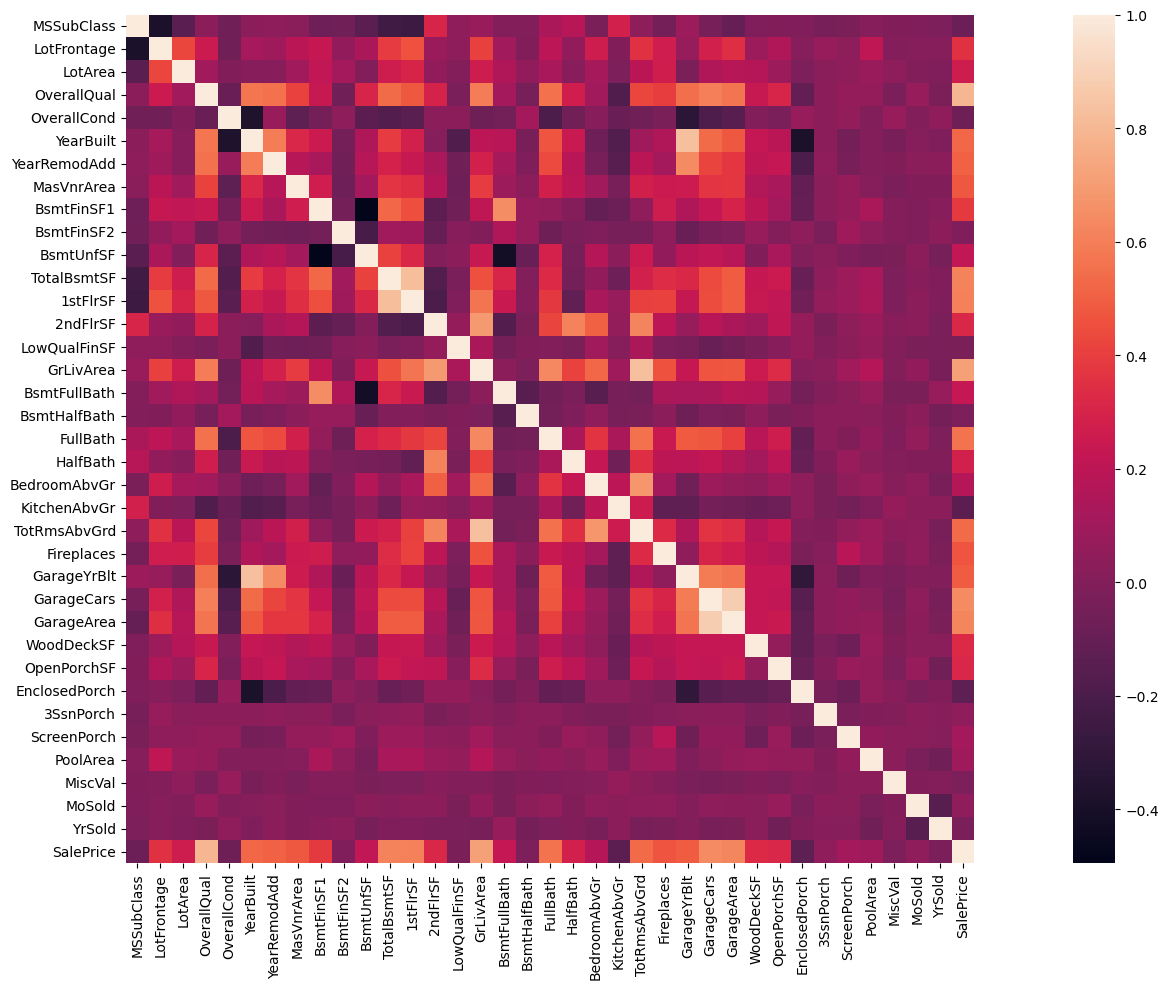

In [4]:
plt.figure(figsize=(20, 10))
sns.heatmap(house_data.corr(), square=True)
plt.tight_layout()

In [5]:
useful_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'RoofMatl', 
                   'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'Condition1', 'YearBuilt', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 
                   'ExterQual', 'ExterCond', 'Foundation', 'TotalBsmtSF', 'Heating', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LandContour', 'GrLivArea', 'GarageType',
                   'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageArea',
                   'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'BsmtFinType1']

house_data = house_data[useful_features + ["SalePrice"]]
test_data = test_data[useful_features]
X = house_data[useful_features]
y = house_data.SalePrice
len(useful_features)

50

In [6]:
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes(exclude=(int, float)).columns
oh_cols = ["Street", "LotShape", "LotConfig", "BldgType", "RoofStyle", "Foundation", "Heating", "MiscFeature"]
ord_cols = ["MSZoning", "Utilities", "LandSlope", "Neighborhood", "Condition1", "HouseStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
            "ExterCond", "ExterQual", "BsmtQual",  "CentralAir", "KitchenQual", "FireplaceQu", "GarageType", "PavedDrive", "BsmtFinType1"]

In [7]:
class CreatePipeline:
    
    def create(self, *, preprocessor, model, verbose=False):
        steps = [("preprocessor", preprocessor),
                 ("model", model)]
        return Pipeline(steps=steps, verbose=verbose)
    
    
    def numerical_transformer(self, *, strategy="mean", **params):
        """Transform numerical columns using `SimpleImputer`.
        params:
            strategy: "mean" | "median" | "most_frequent" | "constant"
            **params: extra keyword args for SimpleImputer"""
        
        transformer = SimpleImputer(strategy=strategy, **params)
        return transformer
    
    
    def categorical_transformer(self, *, imp_strategy="most_frequent", encoder_type="Ordinal", imp_params={}, encoder_params={}):
        """Transform categorical columns by making Pipeline
        `SimpleImputer` | `OneHotEncoder` | `OrdinalEncoder`.
        args:
            imp_strategy: strategy for imputer values can be
                "most_frequent" | "constant"
            encoder_type: encoder type,
                "Ordinal" | "OneHot"
        kwargs:
            imp_params: keyword args for `SimpleImputer`.
            encoder_params: keyword args for encoder.`
        """
        if not encoder_type in ("Ordinal", "OneHot"):
            raise ValueError(f"Inappropriate value for encoder_type passed: {encoder_type}\
            Takes one of 'Ordinal' | 'OneHot'.")
        
        encoder = OrdinalEncoder if encoder_type=="Ordinal" else OneHotEncoder
        transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy=imp_strategy, **imp_params)),
            (encoder_type, encoder(**encoder_params))
        ])
        return transformer
    
    def data_preprocessor(self, *, transformers):
        """Preprocess the data using `ColumnTransformer`.
        Pass extact list of transformers
        to be passed in `ColumnTransformer`.
        each tuple consist of: (transformer_name,
                                transformer,
                                list_of_columns)."""
        preprocessor = ColumnTransformer(transformers=transformers)
        return preprocessor
    
    def XGBRegressor_model(self, *, random_state=0, n_estimators=1000, **kwargs):
        """Create `XGBRegressor` model.
        **kwargs: keyword args for XGBRegressor."""
        model = XGBRegressor(random_state=random_state, n_estimators=n_estimators, **kwargs)
        return model

In [8]:
cp = CreatePipeline()

num_transformer = cp.numerical_transformer()
cat_ord_transformer = cp.categorical_transformer(encoder_params={"handle_unknown":"use_encoded_value", "unknown_value":-1})
cat_oh_transformer = cp.categorical_transformer(encoder_type="OneHot", encoder_params={"handle_unknown":"ignore"})

preprocessor = cp.data_preprocessor(
    transformers=[("num", num_transformer, num_cols),
                  ("cat_ord", cat_ord_transformer, ord_cols),
                  ("cat_oh", cat_oh_transformer, oh_cols)
                 ])

my_model = cp.XGBRegressor_model(learning_rate=0.05)

pipeline_1 = cp.create(preprocessor=preprocessor, model=my_model)

In [9]:
scores = -1 * cross_val_score(pipeline_1, X, y, cv=10, verbose=True,
                             scoring="neg_mean_absolute_error")
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.1s finished


array([15195.98721104, 17015.75305009, 15575.79232663, 18267.4460884 ,
       19745.83128211, 15499.66663099, 15307.10686002, 14926.47241545,
       17860.43771404, 16516.01452804])

In [10]:
scores.mean()

16591.05081068065

In [11]:
n_estimators = [100, 500, 800, 1000]
learning_rates = [0.5, 0.1, 0.08, 0.05]
maes = {}
for i, (n_estimator, learning_rate) in enumerate(zip(n_estimators, learning_rates), start=1):
    model = cp.XGBRegressor_model(n_estimators=n_estimator, learning_rate=learning_rate)
    pipeline = cp.create(preprocessor=preprocessor, model=model)
    mae = -1 * cross_val_score(pipeline, X, y, cv=10, verbose=True,
                             scoring="neg_mean_absolute_error")
    maes[i] = (n_estimator, learning_rate, mae.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.5s finished


In [12]:
for key in maes:
    n_estimator, learning_rate, mae = maes[key]
    print(f"{key}. N_estimators={n_estimator}, Learning_rate: {learning_rate}, Score: {mae}")

1. N_estimators=100, Learning_rate: 0.5, Score: 19268.648151220037
2. N_estimators=500, Learning_rate: 0.1, Score: 16495.916165453767
3. N_estimators=800, Learning_rate: 0.08, Score: 16496.006555008564
4. N_estimators=1000, Learning_rate: 0.05, Score: 16591.05081068065


In [13]:
best_n_estimators = 500
best_learning_rate = 0.1

In [14]:
model = cp.XGBRegressor_model(n_estimators=best_n_estimators, learning_rate=best_learning_rate)
final_model = cp.create(preprocessor=preprocessor, model=model)
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'Enclosed...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [15]:
test_preds = final_model.predict(test_data)
test_preds

array([121662.85, 171334.02, 181721.36, ..., 173966.62, 111360.09,
       209294.9 ], dtype=float32)

In [16]:
output = pd.DataFrame({"Id" : test_data.index, 
                       "SalePrice" : test_preds})
output.to_csv("./housing_price_submission_1.csv", index=False)